## Sirs 4 within 24 hours Logistic Regression
#### Objective

The objective of this notebook is to build a traditional logistic regression model to under stand and predict SIR_4 Criteria, as a proxy for a patient contracting Sepsis. This model is build as a reference and for understanding purposes.

#### Data Source

This model predicts All four SIRS critieria occuring within 4 hours of eachother, within 24 hours of any given observation. The data has been right censored, so that only the time leading up to SIRs 4 is being predicted. The dataset has been filtered for adults only (18 and over). The core data set 1 million hourly labs and vital obseservation

#### Background

Adult SIRS Criteria

Manifestations of SIRS include, but are not limited to:

* Body temperature less than 36 °C (96.8 °F) or greater than 38 °C (100.4 °F)

* Heart rate greater than 90 beats per minute

* Tachypnea (high respiratory rate), with greater than 20 breaths per minute; or, an arterial partial pressure of carbon dioxide less than 4.3 kPa (32 mmHg)

* White blood cell count less than 4000 cells/mm³ (4 x 109 cells/L) or greater than 12,000 cells/mm³ (12 x 109 cells/L); or the presence of greater than 10% immature neutrophils (band forms). Band forms greater than 3% is called bandemia or a "left-shift."

When two or more of these criteria are met with or without evidence of infection, patients may be diagnosed with "SIRS." Patients with SIRS and acute organ dysfunction may be termed "severe SIRS."[2][3][7] Note: Fever and an increased white blood cell count are features of the acute-phase reaction, while an increased heart rate is often the initial sign of hemodynamic compromise. An increased rate of breathing may be related to the increased metabolic stress due to infection and inflammation, but may also be an ominous sign of inadequate perfusion resulting in the onset of anaerobic cellular metabolism.

#### Methods

The basic method for this model is Logicstic Regression using L2 regularization and lbfgs solver and no intercepet. Feature were choosen using information gain criteria initially using xgboost from the original lab and vital set (150 + labs and vitals). Using pvalues, recursive feature selection was used to get to the final model.

#### Conclusion

Hiting any of the SIR-4 ciritera greatly increases the odds of hitting all the SIRS 4 criteria. In particular hitting MetSIRS_WBC is associated with a 12 fold increase in the odds of hitting SIRS4 within 24 hours. Thought the simplicity of this model is very useful, it does not provide much in the way of lead time before SIR-4 cccures. Increases in the following variables, are associated with statistically significatnt increases in risk to meet SIR4 criteria. Actual coeffients are listed in above in the feature importance section

In [1]:
from easy_sql.io import Session as session
from easy_sql.utils import read_sql_text
from sklearn.preprocessing import Imputer, StandardScaler
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import pickle
np.random.seed(7)
pd.options.mode.chained_assignment = None
pd.set_option('max_colwidth', 800)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
dsn = 'muscedw'
sql_file_path = 'data/minmal_sirs24.sql'
s = session(dsn)
sql = read_sql_text(sql_file_path)
data = s.get_data(sql)




#### Preproccessing

* Fit a median imputer for numeric columns
* Fit a catagorical One Hot Encodering for the cataogircal columns



In [2]:
from TextMiningMachine.feature_extraction import DataSetBuilder
y_col = 'MetSIRS4_4hr_24'
col_dict = {'cat_cols': ['INV_02_DEV'],
        'imputer_cols': ['PULSE', 'PULSE_OXIMETRY', 'RESPIRATIONS', 'TEMPERATURE', 'PAIN_RATING',
          'BRADEN_SCORE', 'ORAL_INTAKE', 'URINE_OUTPUT', 'Weight', 'BPS', 'BPD' , 'FIO2, ARTERIAL', 'FEED_TUBE_INTAKE',
          'Hr_24_Diff', 'Temp_24_Diff', 'Wbc_24_Diff',
                        'WBC_COUNT','BUN' ,'HEMOGLOBIN','POTASSIUM', 'RR_48_Diff',
                        'MetSIRS_Temp', 'MetSIRS_HR', 'MetSIRS_RR', 'MetSIRS_WBC', 
                         'MetSIRS2', 'MetSIRS3', 'MetSIRS4']}

d = DataSetBuilder(col_dict=col_dict)
d.fit(data)
features = d.transform(data)
features = features.toarray()
y =  np.array(data[y_col])

Unable to read in the stoplist file, using the default nltk stopwords


#### Data Splitting

Split the data into training and test sets¶
A random 33% holdout was used for testing


In [3]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, y, test_size=0.33, random_state=42)

#### Build Logistic Regression Model
Logistict Regression using without intercept

In [4]:
import statsmodels.api as sm
model = sm.GLM(y_train, x_train, family=sm.families.Binomial())
results = model.fit()

#### Test the model against the holdout set

In [5]:
preds_test = results.predict(x_test)
preds_train = results.predict(x_train)
print(preds_test.shape)

auc_test = roc_auc_score(y_test, preds_test) 
auc_train  = roc_auc_score(y_train, preds_train)
print('train auc: ', round(auc_train,4), ' test auc: ', round(auc_test,4))

(330000,)
train auc:  0.9172  test auc:  0.9136


#### Feature Importance


##### Coefficients

coefficients have been exponentiated and reported as the odds increase each variable contributes for a increase of 1 of the varibles.


In [6]:
pd.options.mode.chained_assignment = None
x = results.summary()
coefs = pd.DataFrame(x.tables[1].data)
x = coefs[1:]
x.columns = ['feature_names'] + list(coefs.iloc[0])[1:]
x.loc[0:,'feature_names'] =  d.feature_names 
x['coef'] = np.exp(np.float32(x['coef']))
x.sort_values('coef', ascending=False)

,feature_names,coef,std err,z,P>|z|,[0.025,0.975]
31,MetSIRS_WBC,12.507143,0.063,40.348,0.000,2.404,2.649
28,MetSIRS_Temp,7.904245,0.069,29.940,0.000,1.932,2.203
30,MetSIRS_RR,2.851086,0.074,14.090,0.000,0.902,1.193
29,MetSIRS_HR,1.893070,0.072,8.896,0.000,0.498,0.779
6,INV_02_DEV.ventilator,1.512101,0.041,10.163,0.000,0.334,0.493
26,POTASSIUM,1.151425,0.023,6.216,0.000,0.097,0.185
7,PULSE,1.022653,0.001,20.493,0.000,0.020,0.025
27,RR_48_Diff,1.022550,0.001,16.701,0.000,0.020,0.025
22,Wbc_24_Diff,1.016129,0.001,13.249,0.000,0.014,0.018
11,PAIN_RATING,1.003606,0.002,2.249,0.024,0.000,0.007


#### Find the optimal Cutoff
based on the Matthew Correlation Coefficient 
https://en.wikipedia.org/wiki/Matthews_correlation_coefficient

In [7]:
from sklearn.metrics import matthews_corrcoef as fun
cut_offs = np.arange(1, 100)/175
vals = []
for cut in cut_offs:
    preds_class = [1 if p > cut else 0 for p in preds_train]
    vals.append(fun(y_train, preds_class))
vals = np.array(vals)
best_cut = cut_offs[np.argmax(vals)]  
preds_train_class = [1 if p > best_cut else 0 for p in preds_train]
preds_test_class = [1 if p > best_cut else 0 for p in preds_test]
print('best cut off :', best_cut)  

best cut off : 0.06285714285714286


#### Model Performance  
True Positive Rate and True Negative Rates

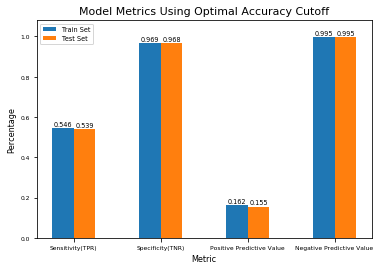

In [8]:
from TextMiningMachine.plot_methods import plot_classification_metrics
plot_classification_metrics(y_train, y_test, preds_train, preds_test, cutoff=best_cut)

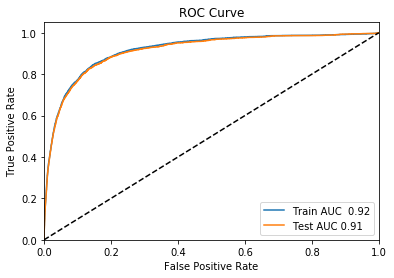

In [9]:
from rnner.plot_methods import plot_auc_curve
plot_auc_curve(y_train, preds_train, y_test, preds_test)

#### Distrobution of Alert Lead Times

mean sirs4_count down 125.9673493872654


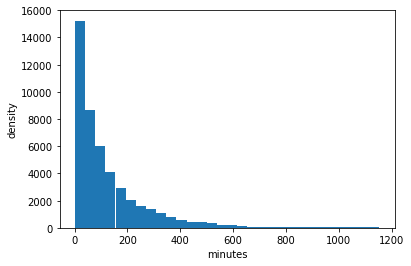

In [10]:
import matplotlib.pyplot as plt
preds_all = results.predict(features)
preds_all_class = [1 if p > best_cut else 0 for p in preds_all]
count_down = np.array(data['SIRS4_4hr_Countdown'])
count_down[np.array(preds_class == 1)]
count_down = count_down[np.isfinite(count_down)]
print('mean sirs4_count down', np.mean(count_down))
plt.hist(count_down, bins=30)
plt.xlabel('minutes')
plt.ylabel('density')
plt.show()

[[316216  10290]
 [  1609   1885]]


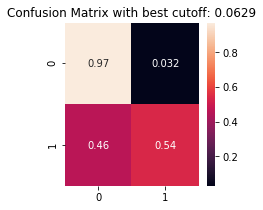

In [11]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, preds_test_class)
print(cm)
cm = np.array([cm[0, :]/np.sum(cm[0, :]), cm[1, :]/np.sum(cm[1, :])])
import seaborn as sn
plt.figure(figsize=(3, 3))
plt.title('Confusion Matrix with best cutoff: ' + str(round(best_cut,4)))
plt.xlabel('True')
plt.ylabel('predicted')
sn.heatmap(cm, annot=True)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\pyCharm\\rnner\\rnner\\resources\\stickman.png'

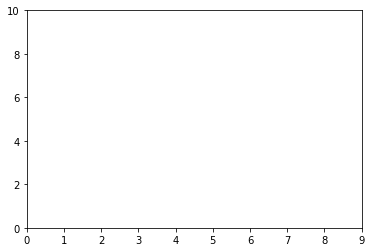

In [12]:
from rnner.plot_methods import ClassificationPlots
cp = ClassificationPlots(y_train= y_test, preds=preds_test)
cp.plot_stick_man( cutoff=best_cut)